#DecisionTrees

Vamos a usar el dataset del Titanic, que contiene los datos de los pasajeros del Titanic, famoso barco que se hundió en su primer viaje en 1912. Dicho dataset contiene los datos de los pasajeros así como información sobre si sobrevivieron o no.

Descripción de los datos

- superviviente El pasajero sobrevivió 0 = No, 1 = Si

- clase_billete Clase de camarote 1 = Primera clase, 2 = Segunda, 3 = Tercera clase (la más pobre)

- genero hombre/mujer

- edad

- n_hermanos_esposos Número de hermanos o pareja a bordo del Titanic

- n_hijos_padres Número de hijos o padres a bordo del Titanic

- precio_billete

- puerto_salida Puerto donde el pasajero tomó el barco (C=Cherbourg, Q=Queenstown, S=Southampton)



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



Los algoritmos de creación de árboles están en el submódulo de sklearn.tree

En cuanto al tipo de algoritmo para crear árboles, scikit-learn usa una versión optimizada del algoritmo CART (Classification and Regression Trees), que permite usar árboles de decisión tanto para problemas de clasificación como de regresión.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

dt=DecisionTreeClassifier()

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

datos =pd.read_csv('titanic.csv')
datos.shape

#Preprocesamiento
y_target = datos['superviviente']

datos = datos.drop(['superviviente'], axis=1)

datos_numericos=datos.select_dtypes(['float64', 'int64'])

datos_categoricos = datos.select_dtypes('object')

pre_numeric = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

pre_categoric = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoding', OneHotEncoder())
])

preprocesssor =ColumnTransformer([
    ('numeric', pre_numeric, datos_numericos.columns),
    ('categoric', pre_categoric, datos_categoricos.columns)
])



In [ ]:
pipeline = Pipeline([
    ('preprocesamiento', preprocesssor),
])

In [ ]:
pipeline.fit(datos).get_feature_names_out()
pasajeros= pd.DataFrame(pipeline.fit_transform(datos), columns=pipeline.fit(datos).get_feature_names_out())
pasajeros.head()


,numeric__clase_billete,numeric__edad,numeric__n_hermanos_esposos,numeric__n_hijos_padres,numeric__precio_billete,categoric__genero_hombre,categoric__genero_mujer,categoric__puerto_salida_C,categoric__puerto_salida_Q,categoric__puerto_salida_S
0,0.827377,-0.592481,0.432793,-0.473674,-0.502445,1.0,0.0,0.0,0.0,1.0
1,-1.566107,0.638789,0.432793,-0.473674,0.786845,0.0,1.0,1.0,0.0,0.0
2,0.827377,-0.284663,-0.474545,-0.473674,-0.488854,0.0,1.0,0.0,0.0,1.0
3,-1.566107,0.407926,0.432793,-0.473674,0.420730,0.0,1.0,0.0,0.0,1.0
4,0.827377,0.407926,-0.474545,-0.473674,-0.486337,1.0,0.0,0.0,0.0,1.0


In [ ]:
dt.fit(pasajeros, y_target)

DecisionTreeClassifier()

0.7812876076356469


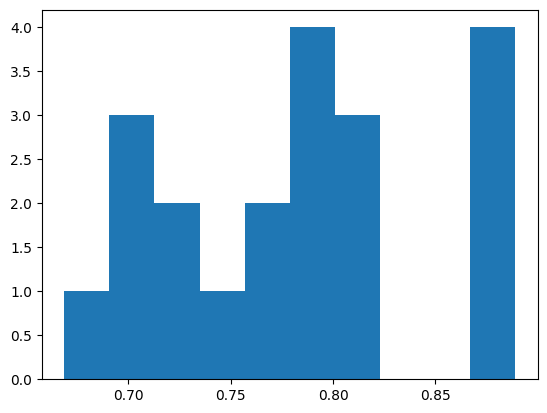

In [ ]:
from sklearn.model_selection import cross_val_score
data_cv =cross_val_score(dt, pasajeros, y_target, cv=20, scoring='roc_auc') # roc_auc nos da el area bajo la curva roc, debe ser cercano a 1
# validaciion cruzada particiona 10 veces la tabla en entrenamiento y prueba
print(data_cv.mean())
plt.hist(data_cv)
plt.show()


Una funcionalidad interesante que tienen los arboles de decision en sklearn es que se pueden visualizar con Graphviz. Para ello tenemos que instalar la libreria con pip install graphviz.

In [ ]:
import graphviz
from sklearn.tree import export_graphviz

In [ ]:

export_graphviz(dt, out_file='tree.dot', feature_names=pasajeros.columns)

Otra funcionalidad que tienen los árboles de decisión en sklearn es que nos dan una indicación de la importancia de cada variable en el modelo, almacenada en el atributo feature_importances_. Calcula la importancia en función de la ganancia de información de cada variable, es decir, que variables separan mejor las distintas clases.

In [ ]:
display(pd.DataFrame({'var':pasajeros.columns,
                      'importances':dt.feature_importances_}).sort_values('importances', ascending=False))

,var,importances
6,categoric__genero_mujer,0.309335
1,numeric__edad,0.260622
4,numeric__precio_billete,0.238752
0,numeric__clase_billete,0.108798
2,numeric__n_hermanos_esposos,0.046460
3,numeric__n_hijos_padres,0.019726
9,categoric__puerto_salida_S,0.009108
7,categoric__puerto_salida_C,0.006690
8,categoric__puerto_salida_Q,0.000508
5,categoric__genero_hombre,0.000000


In [ ]:
dict(zip(
    pasajeros,
    dt.feature_importances_
))

{'numeric__clase_billete': np.float64(0.10879791657472068),
 'numeric__edad': np.float64(0.2606223040988351),
 'numeric__n_hermanos_esposos': np.float64(0.046460401163940734),
 'numeric__n_hijos_padres': np.float64(0.019726308847928614),
 'numeric__precio_billete': np.float64(0.2387521780696334),
 'categoric__genero_hombre': np.float64(0.0),
 'categoric__genero_mujer': np.float64(0.30933518862833864),
 'categoric__puerto_salida_C': np.float64(0.00669014616744941),
 'categoric__puerto_salida_Q': np.float64(0.0005078791435353273),
 'categoric__puerto_salida_S': np.float64(0.009107677305618036)}

Por ejemplo, en este árbol vemos que las variables que tienen más peso a la hora de decidir si un pasajero sobrevive o no son la edad, el género y el precio del billete (¡las mujeres y los niños primero!).

In [ ]:
DecisionTreeClassifier?


Éstos son los parámetros más importantes para los modelos DecisionTreeClassifier de sklearn:

- criterion : El criterio para calcular la reducción de impureza (ganancia de información) al hacer una partición. Se puede elegir entre gini, o entropy

- max_depth : La profundidad máxima del árbol. Definimos profundidad como el número de nodos que atraviesa una observación (cuantas "preguntas" se le hacen).

- max_features: El máximo numero de particiones potenciales se consideran al evaluar un nodo.

- max_leaf_nodes : Límite de hojas para el árbol.

- min_impurity_decrease : la ganancia de información mínima en un nodo para hacer una partición. (Si no hay ninguna partición que cumpla este criterio, se para el desarrollo del árbol en dicho nodo).

- class_weight : Para clases imbalanceadas, podemos pasar el argumento class_weight, como un diccionario de {clase: peso} para que sklearn tenga en cuenta los pesos. Alternativamente, podemos pasar el string balanced para que sklearn genere pesos en función del número de muestras de cada clase.

Los árboles de decisión tienden a sobreajustar cuando tienen demasiada complejidad. Los siguientes parámetros ayudan a controlarla:

- min_samples_leaf : Mínimo número de observaciones en un nodo para considerar un nodo como una hoja. Por defecto es 1, ésto significa que sklearn solo para de hacer particiones cuando un nodo tiene sólo 1 observación.

- min_samples_split : Mínimo número de observaciones en un nodo para generar una partición. Por defecto es 2, esto significa que sklearn por defecto siempre va a intentar particionar un nodo con 2+ elementos.

In [ ]:
simple_tree = DecisionTreeClassifier(max_depth=3)
simple_tree.fit(pasajeros, y_target)
cross_val_score(simple_tree, pasajeros, y_target, cv=10, scoring='roc_auc').mean()

np.float64(0.8502134227428346)

In [ ]:
export_graphviz(simple_tree, out_file='simple_tree.dot', feature_names=pasajeros.columns)

In [ ]:
balanced_tree= DecisionTreeClassifier(class_weight='balanced')
balanced_tree.fit(pasajeros, y_target)
cross_val_score(balanced_tree, pasajeros, y_target, cv=10, scoring='roc_auc').mean()

np.float64(0.7698780522309934)


Además del algoritmo CART para generar árboles, scikit-learn también proporciona una clase de arboles llamada ExtraTreeClassifier, o Extremely Random Trees (Árboles Extremadamente Aleatorios). En estos árboles, en lugar de seleccionar en cada nodo la párticion que proporciona la mayor ganancia de información, ¡se decide una partición al azar!.

In [ ]:
from sklearn.tree import ExtraTreeClassifier
extra_dt = ExtraTreeClassifier(max_features=1)
extra_dt.fit(pasajeros, y_target)
cross_val_score(extra_dt, pasajeros, y_target, cv=10, scoring='roc_auc').mean()


np.float64(0.7580862405568289)

In [ ]:
export_graphviz(extra_dt, out_file='extra_tree.dot', feature_names=pasajeros.columns)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

dt = DecisionTreeClassifier()

busqueda_dist_parametros = {
    "max_depth": sp_randint(2,10),
    "criterion": ['gini', 'entropy'],
    "class_weight": ["balanced", "None"]
}

busqueda = RandomizedSearchCV(estimator=dt,
                             param_distributions=busqueda_dist_parametros,
                             n_iter=30,
                             cv=10,
                             n_jobs=-1,
                             scoring="roc_auc")
busqueda.fit(X=pasajeros, y=y_target)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
160 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/util

RandomizedSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'class_weight': ['balanced', 'None'],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c18f60dd990>},
                   scoring='roc_auc')

In [ ]:
busqueda.best_score_

np.float64(0.8507758254817078)

In [ ]:
busqueda.best_params_

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4}